# Calculate heat index and select heatwave days

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import Image

In [2]:
workspace = 'D:/heat/data/'

In [3]:
# Import climatological Data
weather = pd.read_csv(workspace + '2024_72505394728.csv', low_memory=False)
weather = weather[(weather['TMP'] != '+9999,9') & (weather['DEW'] != '+9999,9')] # Extract outliers
weather = weather[['DATE', 'TMP', 'DEW']] # Select only date, temperature, and dew point columns

# Convert the 'DATE' column to a datetime format
weather['DATE'] = pd.to_datetime(weather['DATE'])

# Set start and end date as a summer season
start_date = '2024-06-01'
end_date = '2024-08-31'
weather = weather[(weather['DATE'] >= start_date) & (weather['DATE'] <= end_date)]
weather

,DATE,TMP,DEW
5014,2024-06-01 00:51:00,"+0217,5","+0056,5"
5015,2024-06-01 01:51:00,"+0211,5","+0050,5"
5016,2024-06-01 02:51:00,"+0206,5","+0039,5"
5017,2024-06-01 03:51:00,"+0189,5","+0050,5"
5018,2024-06-01 04:51:00,"+0189,5","+0044,5"
...,...,...,...
7856,2024-08-30 19:51:00,"+0222,5","+0150,5"
7857,2024-08-30 20:51:00,"+0222,5","+0150,5"
7858,2024-08-30 21:51:00,"+0217,5","+0139,5"
7859,2024-08-30 22:51:00,"+0217,5","+0144,5"


In [4]:
# Extract temperature and dew point in Celsius
def parse_temp(value):
    """Extract °C from NOAA ISD format"""
    raw = value.split(',')[0]
    return float(raw) / 10

weather['temp_c'] = weather['TMP'].apply(parse_temp)
weather['dew_c'] = weather['DEW'].apply(parse_temp)

# Convert Celsius to Fahrenheit
weather['temp_f'] = weather['temp_c'] * 9/5 + 32
weather['dew_f'] = weather['dew_c'] * 9/5 + 32

### ☀️💧 Heat Index

<div align="center">
  <img src="https://www.weather.gov/images/safety/heatindexchart-650.jpg" alt="Heat Index Chart" width="600">
</div>

<br>

The **Heat Index (HI)**, also known as *apparent temperature* or *feels like temperature*, is a measure of how hot it actually feels to the hum body.  
It is calculated using air temperature and relative humidity. Even if the temperature is not very high, people feel hotter with high relative humidity, as it reduces the body's ability to cool itself through sweat eva ation.  
Therefore, it is more beneficial to consider the heat index when studying extreme heat impacts.

<br>

> $$
\text{Heat Index} = -42.379 + 2.04901523T + 10.14333127R - 0.22475541TR - 6.83783 \times 10^{-3}T^2 - 5.481717 \times 10^{-2}R^2 + 1.22874 \times 10^{-3}T^2R + 8.5282 \times 10^{-4}TR^2 - 1.99 \times 10^{-6}T^2R^2
$$
> Where:  
> *T* is the air temperature (°F)  
> *R* is relative humidity (percentage)  

<br>

| Classification      | Heat Index     | Effect on the body                                                                 |
|---------------------|----------------|-------------------------------------------------------------------------------------|
| **Caution**         | 80°F - 90°F    | Fatigue possible with prolonged exposure and/or physical activity                  |
| **Extreme Caution** | 90°F - 103°F   | Heat stroke, heat cramps, or heat exhaustion possible with prolonged exposure      |
| **Danger**          | 103°F - 124°F  | Heat cramps or heat exhaustion likely, heat stroke possible                        |
| **Extreme Danger**  | 125°F or higher| Heat stroke highly likely                                                          |

<br>

**Reference**  
- NOAA: [https://www.weather.gov/ama/heatindex](https://www.weather.gov/ama/heatindex)
weather.gov/ama/heatindex](https://www.weather.gov/ama/heatindex)


In [5]:
# Compute Relative Humidity (RH) from temperature (°C) and dew point (°C)
def compute_rh(temp_c, dew_c):
    es = 6.11 * 10 ** ((7.5 * temp_c) / (237.3 + temp_c))  # Saturation vapor pressure
    e = 6.11 * 10 ** ((7.5 * dew_c) / (237.3 + dew_c))     # Actual vapor pressure
    rh = 100 * e / es
    return np.clip(rh, 0, 100)

weather['rh'] = weather.apply(lambda row: compute_rh(row['temp_c'], row['dew_c']), axis=1)

# Compute Heat Index (HI) from temperature (°F) and RH (%)
def compute_heat_index(temp_f, rh):
    c1 = -42.379
    c2 = 2.04901523
    c3 = 10.14333127
    c4 = -0.22475541
    c5 = -0.00683783
    c6 = -0.05481717
    c7 = 0.00122874
    c8 = 0.00085282
    c9 = -0.00000199

    hi = (c1 + c2 * temp_f + c3 * rh + c4 * temp_f * rh + c5 * temp_f ** 2 +
          c6 * rh ** 2 + c7 * temp_f ** 2 * rh + c8 * temp_f * rh ** 2 +
          c9 * temp_f ** 2 * rh ** 2)
    return hi

weather['heat_index'] = weather.apply(lambda row: compute_heat_index(row['temp_f'], row['rh']), axis=1)

In [6]:
# Extract the row with the highest 'heat_index' for each date
max_hi_per_day = weather.loc[weather.groupby(weather['DATE'].dt.date)['heat_index'].idxmax()]
max_hi_per_day.to_csv("2024_max_hi_per_day.csv", index=False)

max_hi_per_day

,DATE,TMP,DEW,temp_c,dew_c,temp_f,dew_f,rh,heat_index
5024,2024-06-01 08:51:00,"+0156,5","+0056,5",15.6,5.6,60.08,42.08,51.318885,82.881477
5058,2024-06-02 17:51:00,"+0267,5","+0144,5",26.7,14.4,80.06,57.92,46.833813,80.560454
5084,2024-06-03 18:51:00,"+0300,5","+0122,5",30.0,12.2,86.00,53.96,33.495204,84.256975
5110,2024-06-04 19:51:00,"+0261,5","+0156,5",26.1,15.6,78.98,60.08,52.416397,80.122037
5144,2024-06-05 17:18:00,"+0250,5","+0194,5",25.0,19.4,77.00,66.92,71.117938,78.757465
...,...,...,...,...,...,...,...,...,...
7739,2024-08-26 16:51:00,"+0289,5","+0172,5",28.9,17.2,84.02,62.96,49.276382,85.002952
7767,2024-08-27 19:51:00,"+0289,5","+0172,5",28.9,17.2,84.02,62.96,49.276382,85.002952
7792,2024-08-28 19:51:00,"+0322,5","+0211,5",32.2,21.1,89.96,69.98,52.037773,95.459131
7797,2024-08-29 00:51:00,"+0306,5","+0200,5",30.6,20.0,87.08,68.00,53.249329,90.644265


In [7]:
high_hi = max_hi_per_day[max_hi_per_day['heat_index'] >= 90]
high_hi = high_hi.reset_index(drop=True)
high_hi # 28 rows

,DATE,TMP,DEW,temp_c,dew_c,temp_f,dew_f,rh,heat_index
0,2024-06-18 16:51:00,"+0300,5","+0217,5",30.0,21.7,86.00,71.06,61.182545,91.527521
1,2024-06-19 17:51:00,"+0306,5","+0228,5",30.6,22.8,87.08,73.04,63.208650,94.592234
2,2024-06-20 17:51:00,"+0322,5","+0178,5",32.2,17.8,89.96,64.04,42.385791,91.446449
3,2024-06-21 16:51:00,"+0339,5","+0200,5",33.9,20.0,93.02,68.00,44.205578,97.494660
4,2024-06-22 16:51:00,"+0333,5","+0211,5",33.3,21.1,91.94,69.98,48.918553,97.843384
5,2024-06-23 16:51:00,"+0333,5","+0217,5",33.3,21.7,91.94,71.06,50.749221,98.832923
6,2024-06-26 17:51:00,"+0322,5","+0189,5",32.2,18.9,89.96,66.02,45.412435,92.588475
7,2024-06-30 19:38:00,"+0289,5","+0233,5",28.9,23.3,84.02,73.94,71.834075,91.121356
8,2024-07-05 18:51:00,"+0322,5","+0222,5",32.2,22.2,89.96,71.96,55.656335,97.241913
9,2024-07-06 17:51:00,"+0322,5","+0222,5",32.2,22.2,89.96,71.96,55.656335,97.241913


min     69.359229
max    100.858370
Name: heat_index, dtype: float64

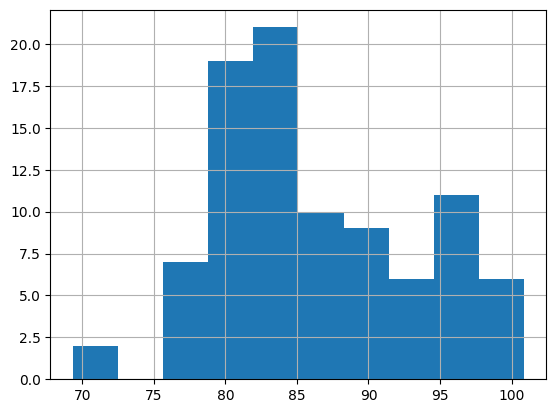

In [8]:
max_hi_per_day['heat_index'].hist(bins=10)
max_hi_per_day['heat_index'].agg(['min', 'max'])

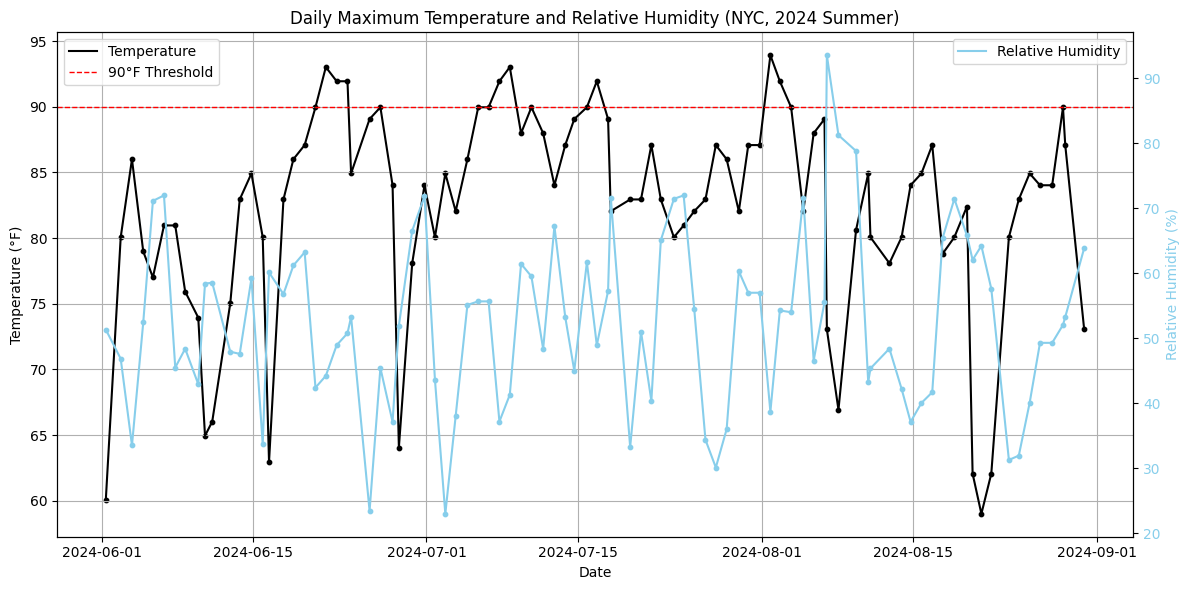

In [9]:
# Daily maximum temperature and relative humidity

fig, ax1 = plt.subplots(figsize=(12, 6))

# Left Y-axis: Temperature
ax1.plot(max_hi_per_day['DATE'], max_hi_per_day['temp_f'], label='Temperature', color='black')
ax1.scatter(max_hi_per_day['DATE'], max_hi_per_day['temp_f'], color='black', s=10)
ax1.axhline(90, color='red', linestyle='--', linewidth=1, label='90°F Threshold')
ax1.set_xlabel("Date")
ax1.set_ylabel("Temperature (°F)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title("Daily Maximum Temperature and Relative Humidity (NYC, 2024 Summer)")
ax1.grid(True)
ax1.legend(loc='upper left')
ax1.tick_params(axis='x', rotation=0)

# Right Y-axis: Relative Humidity
ax2 = ax1.twinx()
ax2.plot(max_hi_per_day['DATE'], max_hi_per_day['rh'], label='Relative Humidity', color='skyblue')
ax2.scatter(max_hi_per_day['DATE'], max_hi_per_day['rh'], color='skyblue', s=10)
ax2.set_ylabel("Relative Humidity (%)", color='skyblue')
ax2.tick_params(axis='y', labelcolor='skyblue')
ax2.legend(loc='upper right')

# Adjust the layout and save the figure
fig.tight_layout()
plt.savefig("2024_temp_with_rh.png", dpi=300, bbox_inches='tight')
plt.show()

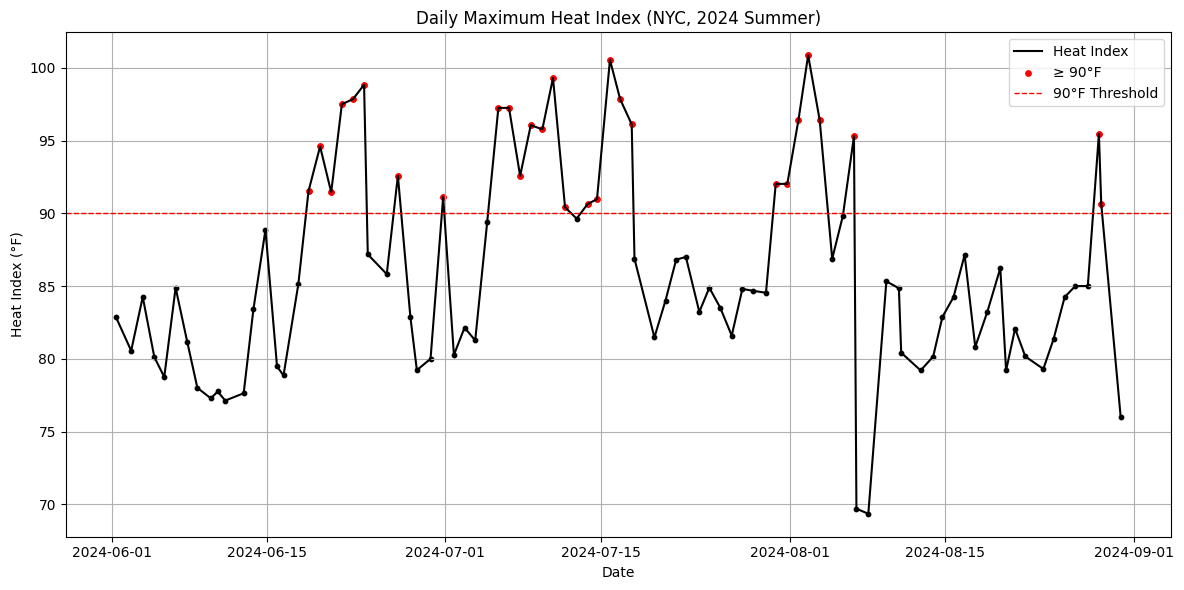

In [10]:
# Daily maximum heat index

# Define red line period
start_red = pd.to_datetime("2024-05-01")
end_red = pd.to_datetime("2024-09-30")

# Create a mask for the red-highlighted period
red_period = (max_hi_per_day['DATE'] >= start_red) & (max_hi_per_day['DATE'] <= end_red)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(max_hi_per_day['DATE'], max_hi_per_day['heat_index'], label='Heat Index', color='black')

# Point
plt.scatter(max_hi_per_day['DATE'], max_hi_per_day['heat_index'], color='black', s=10)
high_hi = max_hi_per_day[max_hi_per_day['heat_index'] >= 90] # Red point over 90°F
plt.scatter(high_hi['DATE'], high_hi['heat_index'], color='red', s=15, label='≥ 90°F')

# Reference line at 90°F
plt.axhline(90, color='red', linestyle='--', linewidth=1, label='90°F Threshold')

# X axis label
plt.xticks(rotation=0)

# Formatting
plt.title("Daily Maximum Heat Index (NYC, 2024 Summer)")
plt.xlabel("Date")
plt.ylabel("Heat Index (°F)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=0)

# Save the figure
plt.savefig("2024_heat.png", dpi=300, bbox_inches='tight')

plt.show()